In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import sklearn as sk
import sklearn.linear_model


import PlaceCellAnalysis as pc
import utilities as u
import preprocessing as pp
import behavior as b
import BayesianDecoding as bd


%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
df = pp.load_session_db()
df = df[df['Imaging']==1]
df = df.sort_values(['MouseName','DateTime','SessionNumber'])

G:\My Drive\VR_Data\TwoTower\behavior.sqlite


In [3]:
mouse = '4139219.2'
df_mouse = df[df['MouseName'].str.match(mouse)]
df_mouse = df_mouse[df_mouse['Track'].str.match('TwoTower_noTimeout') | df_mouse['Track'].str.match('TwoTower_Timeout')]

sess = df_mouse.iloc[10]


In [6]:
VRDat,C,S,A = pp.load_scan_sess(sess)
#C = sp.stats.zscore(C,axis=0)
#cmax = np.max(C,axis=0)
#print(cmax.shape)
#C= np.divide(C,np.dot(np.ones([C.shape[0],1]),cmax[np.newaxis,:]))
trial_info, tstart_inds, teleport_inds = u.by_trial_info(VRDat)
S_trial_mat, occ, edges, centers = u.make_pos_bin_trial_matrices(S,VRDat.pos._values,tstart_inds,teleport_inds)
C_trial_mat, occ, edges, centers = u.make_pos_bin_trial_matrices(C,VRDat.pos._values,tstart_inds,teleport_inds)


num aberrant ttls 0.0
29258 (29258,) (29258, 20) 90985
frame diff 0


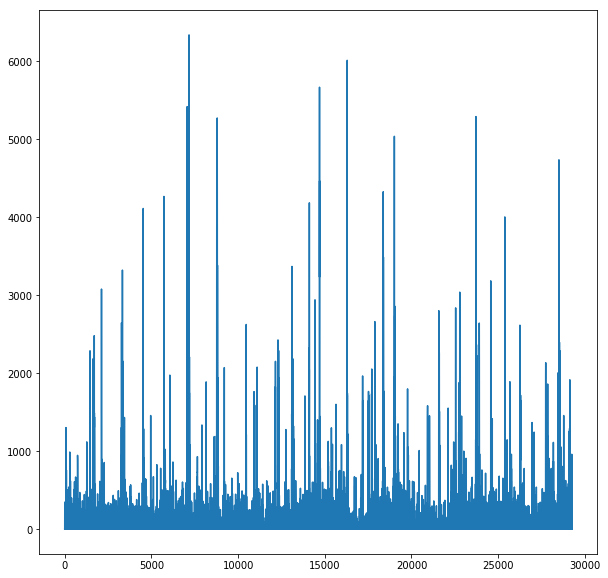

In [7]:
cell = 150
f,ax = plt.subplots(figsize = [10,10])
ax.plot(S[:,cell])

In [8]:
CC = S[VRDat.morph==1,:]
thr = int(.7*CC.shape[0])
mdl = sk.linear_model.ElasticNetCV()
mask = np.ones([CC.shape[1],])
mask[cell]=0
mask = mask>0
C_tr,C_tst = CC[:thr,mask ],CC[thr-1:-2,mask]
y_tr, y_tst = CC[1:thr,(1-mask)>0],CC[thr:,(1-mask)>0]

In [9]:
a=np.arange(3,10)
def trunc_toep(vec,k=10):
    T = sp.linalg.toeplitz(vec.ravel())
    trilm = np.tril_indices(T.shape[0])
    T[trilm]=0
    return T[:,-k:]

def conv_feats(X,K=5):
    XX = np.zeros([X.shape[0],K*X.shape[1]])
    print(XX.shape)
    for k in range(1,K+1):
        print(X[:-1,:].shape)
        XX[k:,X.shape[1]*(k-1):X.shape[1]*(k)] = X[:-k,:]
    return XX

tmp = C[:,:5]
XX = conv_feats(tmp)

(29258, 25)
(29257, 5)
(29257, 5)
(29257, 5)
(29257, 5)
(29257, 5)


In [10]:
XX_tr, XX_tst = conv_feats(C_tr), conv_feats(C_tst)

(5177, 8970)
(5176, 1794)
(5176, 1794)
(5176, 1794)
(5176, 1794)
(5176, 1794)
(2219, 8970)
(2218, 1794)
(2218, 1794)
(2218, 1794)
(2218, 1794)
(2218, 1794)


In [11]:
mdl.fit(XX_tr[1:,:],y_tr.ravel())
y_hat = mdl.predict(XX_tst)

C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


KeyboardInterrupt: 

In [ ]:
f,ax = plt.subplots(figsize=[15,5])
ax.plot(y_tst)
ax.plot(y_hat)